In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True)

from jne_functions import *
from ipywidgets import interactive, FloatSlider
import xgboost as xgb
from catboost import CatBoostClassifier, Pool

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from scipy.stats import uniform
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.metrics import make_scorer, precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

In [2]:
df=pd.read_csv('bank_marketing_modified.csv')
df

,Unnamed: 0,age,job,marital,education,default,housing,loan,contact,month,...,cons.conf.idx,euribor3m,nr.employed,deposit,age_group,season,pdays_bin,year,employment,month_num
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,-36.4,4.857,5191.0,0,Middle-aged,spring,0,2008,employed,5
1,1,57,services,married,high.school,unknown,no,no,telephone,may,...,-36.4,4.857,5191.0,0,Middle-aged,spring,0,2008,employed,5
2,2,37,services,married,high.school,no,yes,no,telephone,may,...,-36.4,4.857,5191.0,0,Adult,spring,0,2008,employed,5
3,3,40,admin.,married,basic.6y,no,no,no,telephone,may,...,-36.4,4.857,5191.0,0,Middle-aged,spring,0,2008,employed,5
4,4,56,services,married,high.school,no,no,yes,telephone,may,...,-36.4,4.857,5191.0,0,Middle-aged,spring,0,2008,employed,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,41183,73,retired,married,professional.course,no,yes,no,cellular,nov,...,-50.8,1.028,4963.6,1,Senior,fall,0,2010,retired,11
41172,41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,...,-50.8,1.028,4963.6,0,Middle-aged,fall,0,2010,employed,11
41173,41185,56,retired,married,university.degree,no,yes,no,cellular,nov,...,-50.8,1.028,4963.6,0,Middle-aged,fall,0,2010,retired,11
41174,41186,44,technician,married,professional.course,no,no,no,cellular,nov,...,-50.8,1.028,4963.6,1,Middle-aged,fall,0,2010,employed,11


In [3]:
X=df.loc[:,['campaign','previous','emp.var.rate','poutcome','euribor3m','nr.employed',
            'cons.price.idx','cons.conf.idx','employment','marital','education',
            'housing','loan','day_of_week','pdays_bin','age_group','default','month','contact','year']]
y=df['deposit']

In [4]:
n_fold=5
folds=StratifiedKFold(n_splits=n_fold,shuffle=True, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
cat_features=[3,8,9,10,11,12,13,14,15,16,17,18,19]
X_test=Pool(data=X_test, cat_features=cat_features)
scores=[]
prediction=np.zeros(X_test.shape[0])
for fold_n, (train_index, val_index) in enumerate(folds.split(X,y)):
    X_train,X_val=X.iloc[train_index],X.iloc[val_index]
    y_train, y_val=y[train_index],y[val_index]
    
    train_set=Pool(X_train,y_train,cat_features=cat_features)
    eval_ds=Pool(X_val,y_val,cat_features=cat_features)
    
    kitty_model= CatBoostClassifier(iterations=100,depth=5,
                                    learning_rate=0.5,
                                    loss_function='Logloss',
                                    class_weights=(1,10),
                                    eval_metric='AUC')
    kitty_model.fit(train_set,
                   eval_set=eval_ds,
                   use_best_model=True)
    score=kitty_model.get_best_score()
    scores.append(score)
    
    y_pred=kitty_model.predict_proba(X_test)[:,1]
    prediction += y_pred
prediction /=n_fold

0:	test: 0.7642348	best: 0.7642348 (0)	total: 69.8ms	remaining: 6.91s
1:	test: 0.7882430	best: 0.7882430 (1)	total: 88.3ms	remaining: 4.32s
2:	test: 0.8012796	best: 0.8012796 (2)	total: 105ms	remaining: 3.41s
3:	test: 0.8032396	best: 0.8032396 (3)	total: 122ms	remaining: 2.93s
4:	test: 0.8037133	best: 0.8037133 (4)	total: 139ms	remaining: 2.64s
5:	test: 0.8055603	best: 0.8055603 (5)	total: 157ms	remaining: 2.46s
6:	test: 0.8066330	best: 0.8066330 (6)	total: 174ms	remaining: 2.31s
7:	test: 0.8069123	best: 0.8069123 (7)	total: 191ms	remaining: 2.19s
8:	test: 0.8075673	best: 0.8075673 (8)	total: 209ms	remaining: 2.11s
9:	test: 0.8078411	best: 0.8078411 (9)	total: 224ms	remaining: 2.02s
10:	test: 0.8084176	best: 0.8084176 (10)	total: 242ms	remaining: 1.96s
11:	test: 0.8078716	best: 0.8084176 (10)	total: 259ms	remaining: 1.9s
12:	test: 0.8080086	best: 0.8084176 (10)	total: 273ms	remaining: 1.83s
13:	test: 0.8076813	best: 0.8084176 (10)	total: 291ms	remaining: 1.79s
14:	test: 0.8078761	best:

25:	test: 0.7934579	best: 0.7934579 (25)	total: 435ms	remaining: 1.24s
26:	test: 0.7929419	best: 0.7934579 (25)	total: 450ms	remaining: 1.22s
27:	test: 0.7933300	best: 0.7934579 (25)	total: 467ms	remaining: 1.2s
28:	test: 0.7960496	best: 0.7960496 (28)	total: 483ms	remaining: 1.18s
29:	test: 0.7982097	best: 0.7982097 (29)	total: 501ms	remaining: 1.17s
30:	test: 0.7986079	best: 0.7986079 (30)	total: 518ms	remaining: 1.15s
31:	test: 0.7992758	best: 0.7992758 (31)	total: 536ms	remaining: 1.14s
32:	test: 0.7988974	best: 0.7992758 (31)	total: 554ms	remaining: 1.12s
33:	test: 0.7988988	best: 0.7992758 (31)	total: 569ms	remaining: 1.1s
34:	test: 0.7992032	best: 0.7992758 (31)	total: 584ms	remaining: 1.08s
35:	test: 0.7994553	best: 0.7994553 (35)	total: 599ms	remaining: 1.06s
36:	test: 0.7994579	best: 0.7994579 (36)	total: 614ms	remaining: 1.04s
37:	test: 0.7988918	best: 0.7994579 (36)	total: 629ms	remaining: 1.03s
38:	test: 0.7988918	best: 0.7994579 (36)	total: 645ms	remaining: 1.01s
39:	test

40:	test: 0.8062365	best: 0.8072967 (29)	total: 645ms	remaining: 928ms
41:	test: 0.8063243	best: 0.8072967 (29)	total: 661ms	remaining: 913ms
42:	test: 0.8063909	best: 0.8072967 (29)	total: 677ms	remaining: 898ms
43:	test: 0.8063807	best: 0.8072967 (29)	total: 694ms	remaining: 883ms
44:	test: 0.8063455	best: 0.8072967 (29)	total: 710ms	remaining: 867ms
45:	test: 0.8064791	best: 0.8072967 (29)	total: 720ms	remaining: 845ms
46:	test: 0.8072628	best: 0.8072967 (29)	total: 737ms	remaining: 831ms
47:	test: 0.8072691	best: 0.8072967 (29)	total: 754ms	remaining: 816ms
48:	test: 0.8069585	best: 0.8072967 (29)	total: 769ms	remaining: 800ms
49:	test: 0.8064890	best: 0.8072967 (29)	total: 785ms	remaining: 785ms
50:	test: 0.8066701	best: 0.8072967 (29)	total: 799ms	remaining: 768ms
51:	test: 0.8069658	best: 0.8072967 (29)	total: 815ms	remaining: 753ms
52:	test: 0.8063176	best: 0.8072967 (29)	total: 830ms	remaining: 736ms
53:	test: 0.8062533	best: 0.8072967 (29)	total: 844ms	remaining: 719ms
54:	te

70:	test: 0.7947267	best: 0.7983450 (30)	total: 1.06s	remaining: 435ms
71:	test: 0.7932275	best: 0.7983450 (30)	total: 1.08s	remaining: 420ms
72:	test: 0.7932714	best: 0.7983450 (30)	total: 1.09s	remaining: 404ms
73:	test: 0.7934857	best: 0.7983450 (30)	total: 1.11s	remaining: 389ms
74:	test: 0.7934031	best: 0.7983450 (30)	total: 1.12s	remaining: 374ms
75:	test: 0.7934246	best: 0.7983450 (30)	total: 1.14s	remaining: 358ms
76:	test: 0.7934056	best: 0.7983450 (30)	total: 1.14s	remaining: 342ms
77:	test: 0.7929651	best: 0.7983450 (30)	total: 1.15s	remaining: 326ms
78:	test: 0.7929138	best: 0.7983450 (30)	total: 1.17s	remaining: 312ms
79:	test: 0.7930445	best: 0.7983450 (30)	total: 1.19s	remaining: 297ms
80:	test: 0.7930445	best: 0.7983450 (30)	total: 1.2s	remaining: 282ms
81:	test: 0.7920509	best: 0.7983450 (30)	total: 1.22s	remaining: 268ms
82:	test: 0.7917957	best: 0.7983450 (30)	total: 1.23s	remaining: 253ms
83:	test: 0.7914299	best: 0.7983450 (30)	total: 1.25s	remaining: 238ms
84:	tes

95:	test: 0.7996266	best: 0.8014876 (51)	total: 1.46s	remaining: 61ms
96:	test: 0.7991091	best: 0.8014876 (51)	total: 1.48s	remaining: 45.7ms
97:	test: 0.7991415	best: 0.8014876 (51)	total: 1.49s	remaining: 30.5ms
98:	test: 0.7991246	best: 0.8014876 (51)	total: 1.51s	remaining: 15.2ms
99:	test: 0.7992775	best: 0.8014876 (51)	total: 1.53s	remaining: 0us

bestTest = 0.801487591
bestIteration = 51

Shrink model to first 52 iterations.


In [5]:
cat_fpr, cat_tpr, thresholds = roc_curve(y_test, kitty_model.predict_proba(X_test)[:,1])

0.8222071967659438

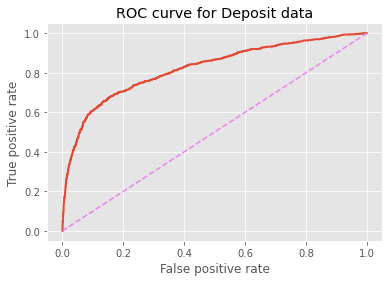

In [6]:
plt.plot(cat_fpr, cat_tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Deposit data');
CAT_AUC=roc_auc_score(y_test, kitty_model.predict_proba(X_test)[:,1])
CAT_AUC

# Logistic Regression

In [7]:
param_grid={'classifier__C':np.logspace(-3,3,100)}
classifiers_2(LogisticRegression(max_iter=600,class_weight={1:10}), X, y)
from jne_functions import pipe, X_train, X_test, y_train, y_test

from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')
rand_log=RandomizedSearchCV(pipe,param_distributions=param_grid,cv=5, scoring=f1, n_iter=25)
rand_log.fit(X_train,y_train)
rand_log.best_params_

/home/jillian/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'classifier__C': 0.4641588833612782}

In [8]:
log_fpr, log_tpr, thresholds = roc_curve(y_test, rand_log.predict_proba(X_test)[:,1])

Logistic Regression ROC AUC score: 0.7933329588028235
Catboost Classifier ROC AUC score: 0.8222071967659438


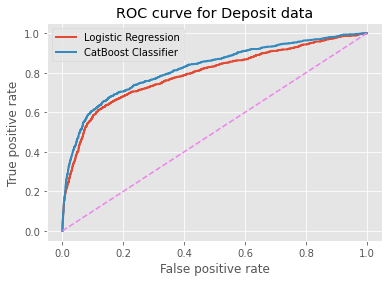

In [9]:
plt.plot(log_fpr, log_tpr,lw=2, label='Logistic Regression')
plt.plot(cat_fpr, cat_tpr,lw=2, label='CatBoost Classifier')
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Deposit data');
LOG_AUC=roc_auc_score(y_test, rand_log.predict_proba(X_test)[:,1])
print('Logistic Regression ROC AUC score:',LOG_AUC)
print('Catboost Classifier ROC AUC score:',CAT_AUC)

# Naive Bayes

In [10]:
    numeric_features=['campaign','previous','emp.var.rate',
                      'cons.price.idx','cons.conf.idx','euribor3m','nr.employed',]
    numeric_transformer= Pipeline(steps=[ ('ss',StandardScaler())])

    categorical_features=['poutcome','employment','marital','education','contact',
                          'default','housing','loan','day_of_week','age_group','year','month']
    categorical_transformer=OneHotEncoder(handle_unknown='error',drop='first')

    preprocessor= ColumnTransformer(
        transformers=[
            ('num',numeric_transformer,numeric_features),
            ('cat', categorical_transformer,categorical_features)
        ])

    pipe=Pipeline(steps=[('prep',preprocessor),
                        ('Berni',BernoulliNB())])
    pipe.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['campaign', 'previous',
                                                   'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['poutcome', 'employment',
                                                   'marital', 'education',
                                                   'contact', 'default',
                                    

In [11]:
NB_fpr, NB_tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:,1])

Logistic Regression ROC AUC score: 0.7933329588028235
Catboost Classifier ROC AUC score: 0.8222071967659438
Bernoulli Naive Bayes ROC AUC score: 0.7710104980606987


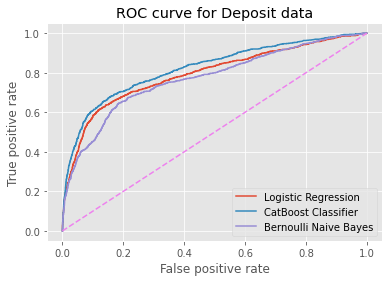

In [12]:
plt.plot(log_fpr, log_tpr,lw=1.5, label='Logistic Regression')
plt.plot(cat_fpr, cat_tpr,lw=1.5, label='CatBoost Classifier')
plt.plot(NB_fpr, NB_tpr,lw=1.5, label='Bernoulli Naive Bayes')
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Deposit data');
NB_AUC=roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])
print('Logistic Regression ROC AUC score:',LOG_AUC)
print('Catboost Classifier ROC AUC score:',CAT_AUC)
print('Bernoulli Naive Bayes ROC AUC score:',NB_AUC)

# Random Forest

In [13]:
param_grid={'classifier__bootstrap': [True],
            'classifier__max_depth': np.arange(10,40,5),
            'classifier__max_features': ['sqrt',None],
            'classifier__min_samples_leaf':np.arange(10,50,5),
            'classifier__min_samples_split': np.arange(10,50,10),
            'classifier__n_estimators':np.arange(100,450,50)}
classifiers_no_stan(RandomForestClassifier(class_weight='balanced_subsample',oob_score=True,n_jobs=-1),X,y)
from jne_functions import pipe, X_train, X_test, y_train, y_test

from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')
rand_RF=RandomizedSearchCV(pipe,param_distributions=param_grid,cv=5, scoring=f1, n_iter=25)
rand_RF.fit(X_train,y_train)
rand_RF.best_params_

{'classifier__n_estimators': 150,
 'classifier__min_samples_split': 30,
 'classifier__min_samples_leaf': 10,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 30,
 'classifier__bootstrap': True}

In [14]:
RF_fpr, RF_tpr, thresholds = roc_curve(y_test, rand_RF.predict_proba(X_test)[:,1])

Logistic Regression ROC AUC score: 0.7933329588028235
Catboost Classifier ROC AUC score: 0.8222071967659438
Bernoulli Naive Bayes ROC AUC score: 0.7710104980606987
Random Forest Classifier ROC AUC score: 0.7886278086839176


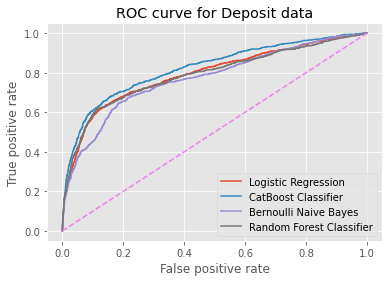

In [15]:
plt.plot(log_fpr, log_tpr,lw=1.5, label='Logistic Regression')
plt.plot(cat_fpr, cat_tpr,lw=1.5, label='CatBoost Classifier')
plt.plot(NB_fpr, NB_tpr,lw=1.5, label='Bernoulli Naive Bayes')
plt.plot(RF_fpr, RF_tpr,lw=1.5, label='Random Forest Classifier')
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Deposit data');
RF_AUC=roc_auc_score(y_test, rand_RF.predict_proba(X_test)[:,1])
print('Logistic Regression ROC AUC score:',LOG_AUC)
print('Catboost Classifier ROC AUC score:',CAT_AUC)
print('Bernoulli Naive Bayes ROC AUC score:',NB_AUC)
print('Random Forest Classifier ROC AUC score:',RF_AUC)

# BalancedRandomForestClassifier

In [16]:
param_grid={'classifier__bootstrap': [True],
            'classifier__max_depth': np.arange(10,40,5),
            'classifier__max_features': ['sqrt',None],
            'classifier__min_samples_leaf':np.arange(10,50,5),
            'classifier__min_samples_split': np.arange(10,50,10),
            'classifier__n_estimators':np.arange(100,450,50)}
classifiers_no_stan(BalancedRandomForestClassifier(class_weight='balanced_subsample',n_jobs=-1),X,y)
from jne_functions import pipe, X_train, X_test, y_train, y_test

from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')
rand_RF_BAL=RandomizedSearchCV(pipe,param_distributions=param_grid,cv=5, scoring=f1, n_iter=25)
rand_RF_BAL.fit(X_train,y_train)
rand_RF_BAL.best_params_

{'classifier__n_estimators': 200,
 'classifier__min_samples_split': 10,
 'classifier__min_samples_leaf': 10,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 25,
 'classifier__bootstrap': True}

In [17]:
BRF_fpr, BRF_tpr, thresholds = roc_curve(y_test, rand_RF_BAL.predict_proba(X_test)[:,1])

Logistic Regression ROC AUC score: 0.7933329588028235
Catboost Classifier ROC AUC score: 0.8222071967659438
Bernoulli Naive Bayes ROC AUC score: 0.7710104980606987
Random Forest Classifier ROC AUC score: 0.7886278086839176
Balanced Random Forest Classifier ROC AUC score: 0.7918387442670289


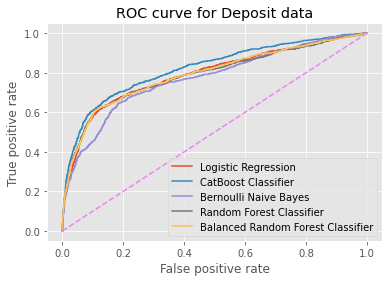

In [18]:
plt.plot(log_fpr, log_tpr,lw=1.5, label='Logistic Regression')
plt.plot(cat_fpr, cat_tpr,lw=1.5, label='CatBoost Classifier')
plt.plot(NB_fpr, NB_tpr,lw=1.5, label='Bernoulli Naive Bayes')
plt.plot(RF_fpr, RF_tpr,lw=1.5, label='Random Forest Classifier')
plt.plot(BRF_fpr, BRF_tpr,lw=1.5, label='Balanced Random Forest Classifier')
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Deposit data');
BRF_AUC=roc_auc_score(y_test, rand_RF_BAL.predict_proba(X_test)[:,1])
print('Logistic Regression ROC AUC score:',LOG_AUC)
print('Catboost Classifier ROC AUC score:',CAT_AUC)
print('Bernoulli Naive Bayes ROC AUC score:',NB_AUC)
print('Random Forest Classifier ROC AUC score:',RF_AUC)
print('Balanced Random Forest Classifier ROC AUC score:',BRF_AUC)

# XGBOOST

In [19]:
param_grid={'classifier__n_estimators':[100,250,500],
            'classifier__use_label_encoder':[False],
           'classifier__max_depth':[3,5,7],
           'classifier__learning_rate':[0.1,0.05,0.15],
           'classifier__subsample':[0.5,0.8,1],
           'classifier__min_child_weight':[3,5,7],
           'classifier__colsample_bytree':[.5,.8,1],
           'classifier__objective':['binary:logistic'],
           'classifier__scale_pos_weight':[8,10]}
classifiers_no_stan(xgb.XGBClassifier(),X,y)
from jne_functions import pipe, X_train, X_test, y_train, y_test

from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')
rand_XGB=RandomizedSearchCV(pipe,param_distributions=param_grid,cv=5, scoring=f1, n_iter=25)
rand_XGB.fit(X_train,y_train)
rand_XGB.best_params_

[17:29:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:17] WARNING: /home/conda/feedstock_r

[17:29:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:43] WARNING: /home/conda/feedstock_r

[17:30:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:12] WARNING: /home/conda/feedstock_r

[17:30:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:36] WARNING: /home/conda/feedstock_r

[17:30:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:31:00] WARNING: /home/conda/feedstock_r

{'classifier__use_label_encoder': False,
 'classifier__subsample': 1,
 'classifier__scale_pos_weight': 8,
 'classifier__objective': 'binary:logistic',
 'classifier__n_estimators': 100,
 'classifier__min_child_weight': 7,
 'classifier__max_depth': 3,
 'classifier__learning_rate': 0.05,
 'classifier__colsample_bytree': 1}

In [20]:
XG_fpr, XG_tpr, thresholds = roc_curve(y_test, rand_XGB.predict_proba(X_test)[:,1])

Logistic Regression ROC AUC score: 0.7933329588028235
Catboost Classifier ROC AUC score: 0.8222071967659438
Bernoulli Naive Bayes ROC AUC score: 0.7710104980606987
Random Forest Classifier ROC AUC score: 0.7886278086839176
Balanced Random Forest Classifier ROC AUC score: 0.7918387442670289
XGBoost Classifier ROC AUC score: 0.7897410785063134


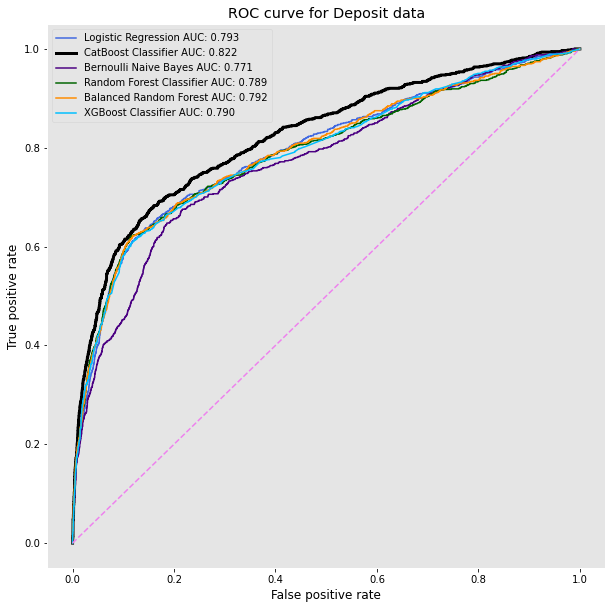

In [29]:
plt.figure(figsize=(10,10))

plt.plot(log_fpr, log_tpr,lw=1.5, label='Logistic Regression AUC: 0.793',c='royalblue')
plt.plot(cat_fpr, cat_tpr,lw=3, label='CatBoost Classifier AUC: 0.822', c='black')
plt.plot(NB_fpr, NB_tpr,lw=1.5, label='Bernoulli Naive Bayes AUC: 0.771',c='indigo')
plt.plot(RF_fpr, RF_tpr,lw=1.5, label='Random Forest Classifier AUC: 0.789',c='darkgreen')
plt.plot(BRF_fpr, BRF_tpr,lw=1.5, label='Balanced Random Forest AUC: 0.792',c='darkorange')
plt.plot(XG_fpr, XG_tpr,lw=1.5, label='XGBoost Classifier AUC: 0.790',c='deepskyblue')
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend()
plt.grid(b=None)
plt.tick_params(colors='black')
plt.xlabel('False positive rate').set_color('black')
plt.ylabel('True positive rate').set_color('black')
plt.title('ROC curve for Deposit data');
XG_AUC=roc_auc_score(y_test, rand_XGB.predict_proba(X_test)[:,1])
print('Logistic Regression ROC AUC score:',LOG_AUC)
print('Catboost Classifier ROC AUC score:',CAT_AUC)
print('Bernoulli Naive Bayes ROC AUC score:',NB_AUC)
print('Random Forest Classifier ROC AUC score:',RF_AUC)
print('Balanced Random Forest Classifier ROC AUC score:',BRF_AUC)
print('XGBoost Classifier ROC AUC score:',XG_AUC)
plt.savefig("ROC_Curves.svg", format="svg");